# Customer Segmentation 💼🔍

In this notebook, I will explore the fascinating realms of customer segmentation and market basket analysis using Python. Our focus will be on leveraging unsupervised learning models to uncover meaningful patterns within customer data and transactional records.

#### Problem Statement

Customer segmentation is a crucial strategy for businesses aiming to understand their customer base better and tailor their marketing efforts accordingly. By dividing customers into distinct groups based on similarities, businesses can personalize their approaches, enhance customer satisfaction, and drive sales.

Market basket analysis, on the other hand, offers insights into customer purchasing behavior by identifying associations between products frequently bought together. This technique enables businesses to optimize product placement, cross-selling strategies, and promotions.

#### Approach

Our objective is to apply unsupervised learning techniques to segment customers effectively and perform market basket analysis on transactional data. By doing so, we aim to uncover valuable insights that can inform strategic decision-making and enhance business performance.

**Created by: Jose Ruben Garcia Garcia**
**March, 2024**


### Loading resources 

In [1]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

%matplotlib inline

### Exploratory Data analysis 

In [2]:
#Reading file
cs_df = pd.read_excel('Online Retail.xlsx')

In [3]:
cs_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#### Dataset Attributes Description

The attributes of the dataset are easily identifiable from their names. We know right away what each of these fields might mean. For the sake of completeness, we include the description of each column here:

- **InvoiceNo**: A unique identifier for the invoice. An invoice number shared across rows means that those transactions were performed in a single invoice (multiple purchases).

- **StockCode**: Identifier for items contained in an invoice.

- **Description**: Textual description of each of the stock item.

- **Quantity**: The quantity of the item purchased.

- **InvoiceDate**: Date of purchase.

- **UnitPrice**: Value of each item.

- **CustomerID**: Identifier for customer making the purchase.

- **Country**: Country of customer.


In [4]:
# Verifying which are the top countries the retailer is shippings its items to

cs_df.Country.value_counts().reset_index().head(10)

,Country,count
0,United Kingdom,495478
1,Germany,9495
2,France,8557
3,EIRE,8196
4,Spain,2533
5,Netherlands,2371
6,Belgium,2069
7,Switzerland,2002
8,Portugal,1519
9,Australia,1259


Since the dataset it's provided from the an UK institution it result clear to see the UK in the top in the list follow by other european countries.

In [5]:
# How many different Customers we have in the dataset
cs_df.CustomerID.unique().shape 

(4373,)

In [6]:
# return the cumulative percentage of the top 13 most frequent customer IDs in the DataFrame
(cs_df.CustomerID.value_counts()/sum(cs_df.CustomerID.value_counts())*100).head(n=13).cumsum()

CustomerID
17841.0    1.962249
14911.0    3.413228
14096.0    4.673708
12748.0    5.814728
14606.0    6.498553
15311.0    7.110850
14646.0    7.623350
13089.0    8.079807
13263.0    8.492020
14298.0    8.895138
15039.0    9.265809
14156.0    9.614850
18118.0    9.930462
Name: count, dtype: float64

In [7]:
#Determining how many unique items the firm is selling
cs_df.StockCode.unique().shape

(4070,)

In [8]:
cs_df.Description.unique().shape

(4224,)

Here we will have the same number of unique items and descriptions but there is a mismatch which means that we have multiple description for some of the stock codes. The next task will be find that codes with mistakes.

In [9]:
#Finding duplicated descriptions
cat_des_df = cs_df.groupby(["StockCode","Description"]).count().reset_index()
cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1].reset_index().head()

,StockCode,count
0,20713,8
1,23084,7
2,21830,6
3,85175,6
4,85172,5


In [10]:
cs_df[cs_df['StockCode'] 
      == cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1].reset_index()['StockCode'][6]]['Description'].unique()

array(['JUMBO BAG VINTAGE CHRISTMAS ', 'came coded as 20713',
       'wrongly coded 20713', '20713 wrongly marked', 20713], dtype=object)

#### Verifying other features 

In [11]:
cs_df.Quantity.describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

In [12]:
cs_df.UnitPrice.describe()

count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

The output above indicates that both of these attributes display negative values, suggesting the presence of return transactions within our dataset. While this occurrence is typical for retailers, it's imperative to address these issues before conducting further analysis. These instances exemplify some of the data quality concerns inherent in our dataset. In real-world scenarios, datasets often contain various imperfections, emphasizing the importance of thoroughly verifying the data before embarking on any analysis.

### Data cleaning

In [13]:
#Filter only the UK transactions as we see that this country has a big different in selling compared to other countries
cs_df = cs_df[cs_df.Country  == 'United Kingdom']

#Separate attribute for total amount
cs_df['amount'] = cs_df.Quantity*cs_df.UnitPrice

#Removing negative or return transactions
cs_df = cs_df[~(cs_df.amount<0)]
cs_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [14]:
#Removing transactions that have a missing value for CustomerID
cs_df = cs_df[~(cs_df.CustomerID.isnull())]
cs_df.shape

(354345, 9)

## RFM in Clustering: Importance and Meaning

RFM (Recency, Frequency, Monetary) is a commonly used approach in customer analysis to segment customers into homogeneous groups based on their buying behavior.

- **Recency**: Refers to the time elapsed since the customer's last purchase. Customers who have made recent purchases are considered more active and valuable to the company.

- **Frequency**: Represents the number of times a customer has made purchases within a specific period. Customers with a high purchase frequency tend to be loyal and generate consistent revenue for the company.

- **Monetary**: Indicates the total monetary value of purchases made by a customer during a specified period. Customers who have spent more money are often considered higher-value for the company.

The importance of RFM in clustering lies in its ability to identify groups of customers with similar buying behavior characteristics. By segmenting customers into groups based on these three criteria, companies can personalize their marketing strategies, promotions, and services to meet the specific needs of each segment. This can lead to increased customer retention, loyalty, and ultimately, a higher return on investment.

In summary, RFM in clustering is a powerful tool for understanding and segmenting the customer base, allowing companies to enhance the effectiveness of their business actions and increase customer satisfaction.


The last information is an introduction as the topic of RFM will be used to create some features in our dataset considering that in this example not from the real world we have few columns with information usable for the future model of clustering.

### Recency 

In [15]:
#Creating recency feature
cs_df.InvoiceDate.max()
cs_df.InvoiceDate.min()
reference_date = cs_df.InvoiceDate.max()
reference_date = reference_date + datetime.timedelta(days = 1)

In [16]:
#Building the recency feature as the number of days before the reference data when a customer made a purchase.

cs_df['days_since_last_purchase'] = reference_date - cs_df.InvoiceDate
cs_df['days_since_last_purchase_num'] = cs_df['days_since_last_purchase']

In [17]:
# Calculate the reference date for computing recency
reference_date = cs_df.InvoiceDate.max() + datetime.timedelta(days=1)

# Calculate the number of days since the last purchase for each customer
customer_history_df = cs_df.groupby('CustomerID').agg({'InvoiceDate': lambda date: (reference_date - date.max()).days}).reset_index()
customer_history_df.rename(columns={'InvoiceDate': 'recency'}, inplace=True)

# Description of the 'recency' column
print(customer_history_df.recency.describe())


count    3921.000000
mean       92.188472
std        99.528995
min         1.000000
25%        18.000000
50%        51.000000
75%       143.000000
max       374.000000
Name: recency, dtype: float64


In [18]:
customer_history_df.head()

,CustomerID,recency
0,12346.0,326
1,12747.0,2
2,12748.0,1
3,12749.0,4
4,12820.0,3


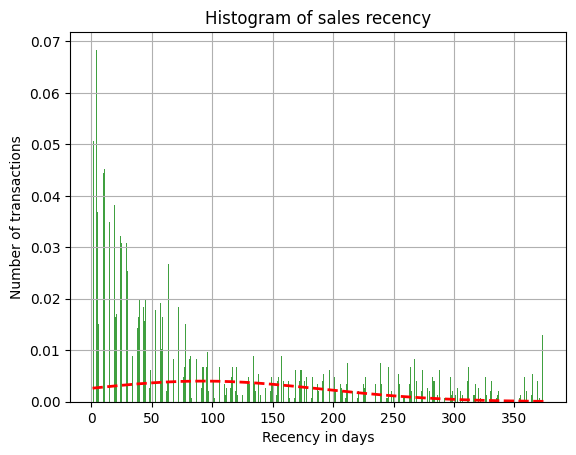

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Extract recency data from customer history DataFrame
x = customer_history_df.recency

# Calculate mean and standard deviation of recency data
mu = np.mean(customer_history_df.recency)
sigma = np.std(customer_history_df.recency)

# Create a histogram of recency data
n, bins, patches = plt.hist(x, 1000, density=True, facecolor='green', alpha=0.75)

# Compute the normal probability density function (PDF)
y = norm.pdf(bins, mu, sigma)

# Plot the PDF as a 'best fit' line
l = plt.plot(bins, y, 'r--', linewidth=2)

# Add labels and title to the plot
plt.xlabel('Recency in days')
plt.ylabel('Number of transactions')
plt.title('Histogram of sales recency')

# Enable grid on the plot
plt.grid(True)

# Show the plot
plt.show()


The histogram reveals a skewed distribution of sales recency, indicating that there is a larger concentration of frequent transactions compared to less recent ones, which are more evenly distributed.

### Frequency and monetary value

In [20]:
#Creating variables and merging

customer_monetary_val = cs_df[['CustomerID', 'amount']].groupby("CustomerID").sum().reset_index()
customer_history_df = customer_history_df.merge(customer_monetary_val, how='outer')
customer_history_df.amount = customer_history_df.amount+0.001
#The 0.001 values was added to the date in order to at least have a little presence of a number, if would not use this probably the zero values will lead to an error

customer_freq = cs_df[['CustomerID', 'amount']].groupby('CustomerID').count().reset_index()
customer_freq.rename(columns={'amount':'frequency'},inplace=True)
customer_history_df = customer_history_df.merge(customer_freq, how='outer')

In [21]:
customer_history_df.head()

,CustomerID,recency,amount,frequency
0,12346.0,326,77183.601,1
1,12747.0,2,4196.011,103
2,12748.0,1,33719.731,4596
3,12749.0,4,4090.881,199
4,12820.0,3,942.341,59


### Data Processing 

The decision of this analysis is to create a K-means model, The main request to create this algorithm is to have the y variable as a centralized value (mean centering value) with this te variable had a mean of 0 and a variance of 1, this help us to ensure that all the variables are in the same range.

Another consideration is that we have very different range values between each variable, to take this issue I will transform all the variables in a log scale. 

In [22]:
#creating a log valued and mean centered version of the dataset
from sklearn import preprocessing
import math 

# Apply logarithm to recency, frequency, and amount columns
customer_history_df['recency_log'] = customer_history_df['recency'].apply(math.log)
customer_history_df['frequency_log'] = customer_history_df['frequency'].apply(math.log)
customer_history_df['amount_log'] = customer_history_df['amount'].apply(math.log)

# Define feature vector
feature_vector = ['amount_log', 'recency_log', 'frequency_log']

# Extract feature matrix X from DataFrame
X = customer_history_df[feature_vector].values

# Standardize features
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

**Logarithmic Transformation and Normal Distribution**

Logarithmic transformation is a common technique used to stabilize variance and reduce skewness in data distributions. When applied to monetary values, such as customer sales amounts, logarithmic transformation can have several beneficial effects.

Firstly, it reduces skewness in the data distribution, leading to a more symmetrical distribution. Additionally, it stabilizes variance across the distribution, which is important for statistical models assuming a normal distribution of errors.

Another benefit is that it centers the data around zero, making it easier to interpret and visualize. Furthermore, by reducing the scale of the data, logarithmic transformation makes the distribution easier to understand and analyze.

It's important to note that logarithmic transformation doesn't guarantee a normal distribution, but it can improve symmetry and variance stability in the data distribution.

#### Visualizing recency, frequency and monetary specs 

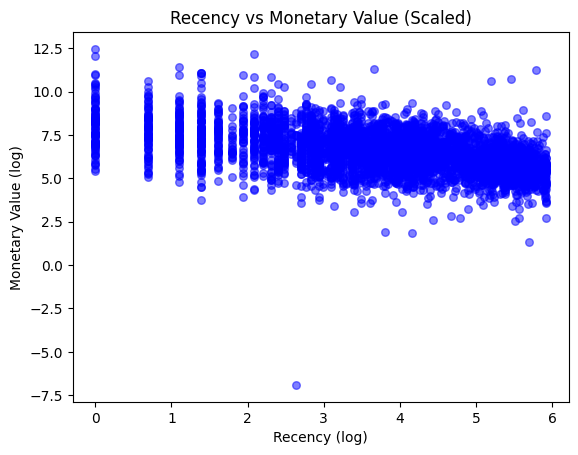

In [23]:
### Visualizing Recency vs Monetary Value (scaled)
# Define scatter plot
plt.scatter(customer_history_df.recency_log, customer_history_df.amount_log, alpha=0.5, s=30, c='blue')

# Add labels and title
plt.xlabel('Recency (log)')
plt.ylabel('Monetary Value (log)')
plt.title('Recency vs Monetary Value (Scaled)')

# Show plot
plt.show()

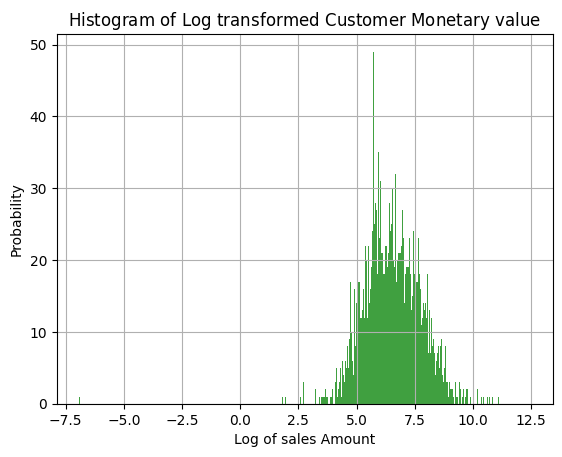

In [24]:
### Visualizing Monetary Value distribution (scaled)

x = customer_history_df.amount_log
n, bins, patches = plt.hist(x,1000, facecolor='green', alpha=0.75)
plt.xlabel('Log of sales Amount')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ Log\ transformed\ Customer\ Monetary\ value}\ $')
plt.grid(True)
plt.show()


The graph show us a distribution resembling normal distribution with mean 0 and variance of 1.

In [25]:
#Visualizing customers information after log transformation 
customer_history_df.head()

,CustomerID,recency,amount,frequency,recency_log,frequency_log,amount_log
0,12346.0,326,77183.601,1,5.786897,0.000000,11.253942
1,12747.0,2,4196.011,103,0.693147,4.634729,8.341890
2,12748.0,1,33719.731,4596,0.000000,8.432942,10.425838
3,12749.0,4,4090.881,199,1.386294,5.293305,8.316516
4,12820.0,3,942.341,59,1.098612,4.077537,6.848367


#### 3D Representation of (R, F, M) features

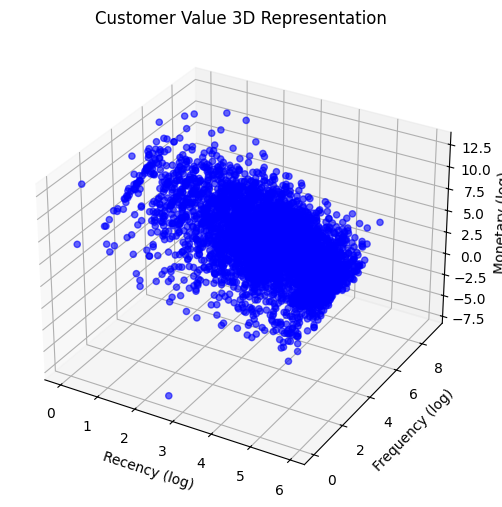

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Extracting data from DataFrame
xs = customer_history_df['recency_log']
ys = customer_history_df['frequency_log']
zs = customer_history_df['amount_log']

# Adjusting scatter plot parameters for better visualization
ax.scatter(xs, ys, zs, s=20, c='blue', alpha=0.6)  # Adjust size and color

# Labels and title
ax.set_xlabel('Recency (log)')
ax.set_ylabel('Frequency (log)')
ax.set_zlabel('Monetary (log)')
ax.set_title('Customer Value 3D Representation')

plt.show()



I have plotted a three-dimensional representation of customer value using recency, frequency, and monetary data. Each point in the plot represents a customer. The x-axis represents the recency of their transactions (logged), the y-axis represents the frequency of transactions (logged), and the z-axis represents the monetary value of transactions (logged). The scatter plot visualizes the distribution of customers based on these three dimensions. Larger and bluer points indicate higher recency, frequency, and monetary values, respectively. This visualization helps us understand the clustering and distribution of customers in terms of their value to the business.

A easy pattern that I found is that people who buy with a higher frequency and more recency tend to spend more based on the increasing trend in monetary value.

## Analyze Customer Segments with Clusters


/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


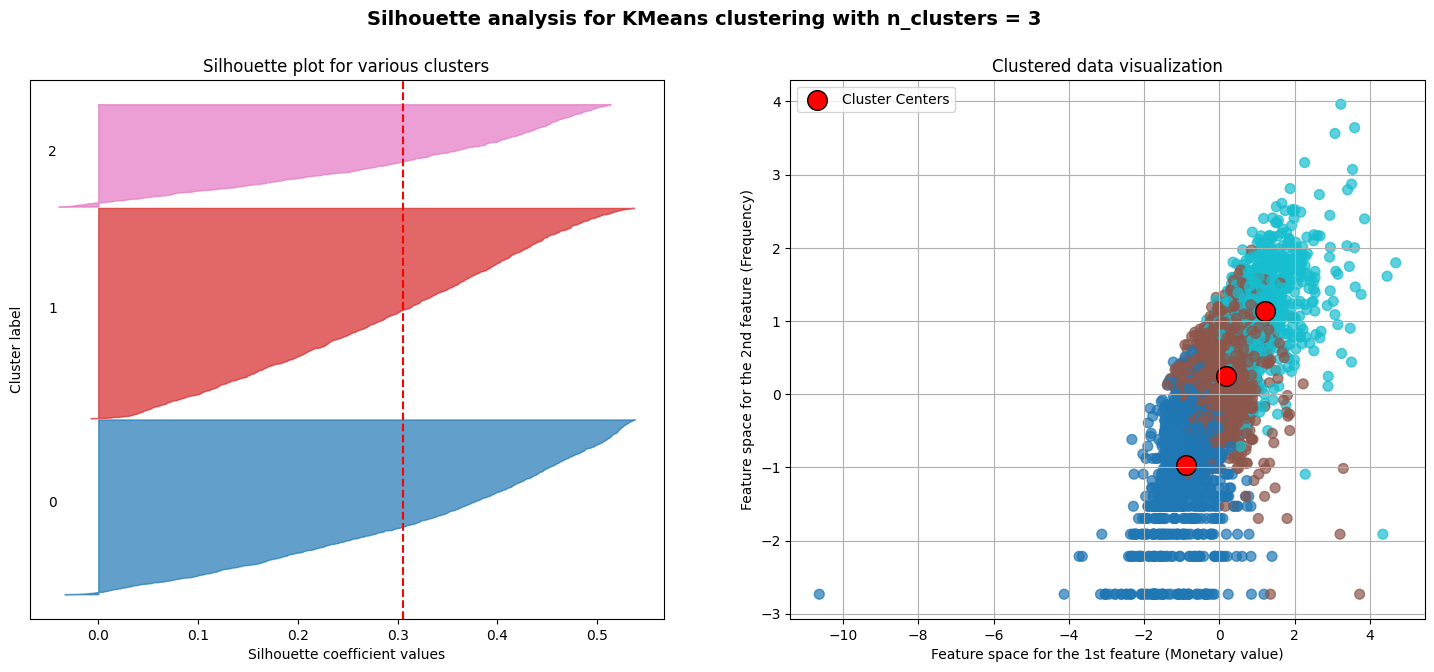

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


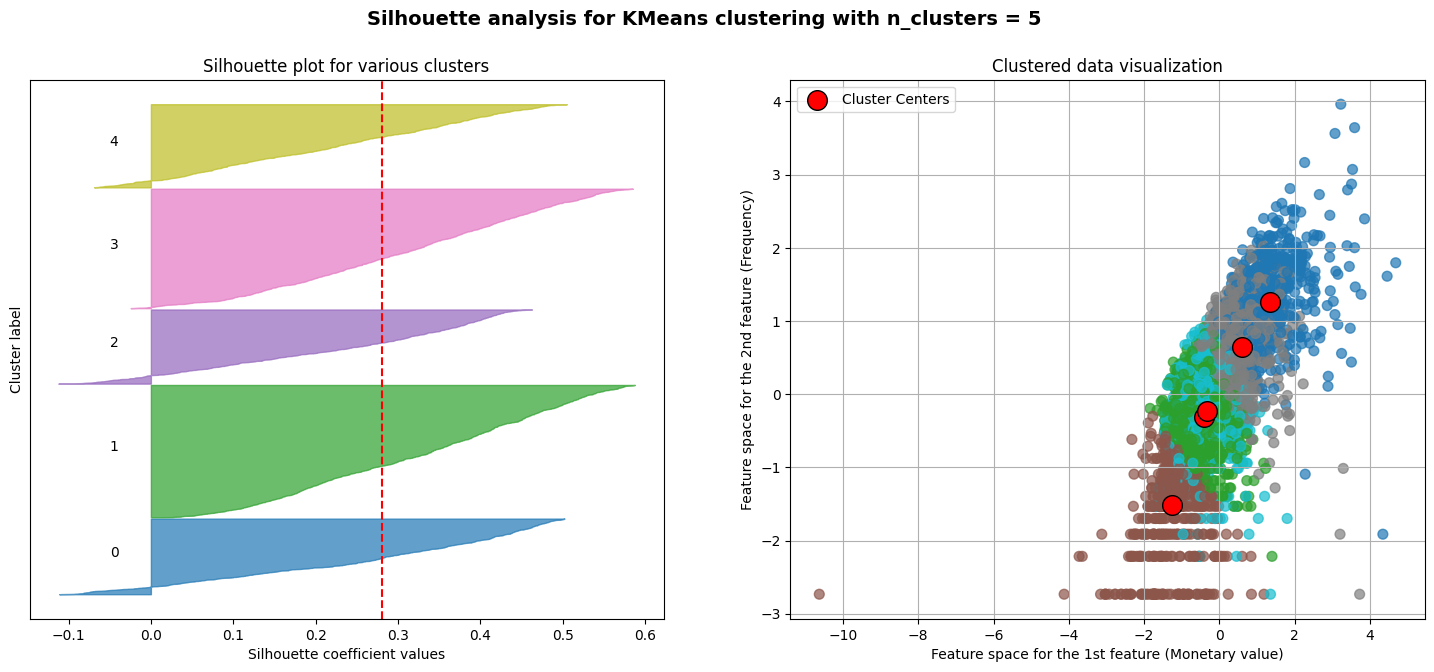

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

X = X_scaled

cluster_centers = dict()

for n_clusters in range(3, 6, 2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    cluster_centers.update({n_clusters: {
        'cluster_center': clusterer.cluster_centers_,
        'silhouette_score': silhouette_avg,
        'labels': cluster_labels}
    })

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.tab10(float(i) / n_clusters)  # Using consistent color map
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("Silhouette plot for various clusters")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])

    ax2.grid(True)  # Add grid lines to scatter plot
    feature1 = 0
    feature2 = 2
    ax2.scatter(X[:, feature1], X[:, feature2], marker='o', s=50, c=cluster_labels, cmap='tab10', alpha=0.7)
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, feature1], centers[:, feature2], marker='o', c='red', s=200, edgecolor='black', label='Cluster Centers')

    ax2.set_title("Clustered data visualization")
    ax2.set_xlabel("Feature space for the 1st feature (Monetary value)")
    ax2.set_ylabel("Feature space for the 2nd feature (Frequency)")
    ax2.legend()

    plt.suptitle(("Silhouette analysis for KMeans clustering with n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')
    plt.show()


The code performs a clustering analysis using the KMeans algorithm and visualizes the results using two subplots:

**Silhouette Plot:** It generates a silhouette plot to assess the cohesion and separation of the clusters found by KMeans. Each cluster is represented as a band, where the width of the band indicates the size of the cluster, and the height indicates the silhouette score for each point in the cluster. Additionally, a dashed vertical line indicates the average silhouette coefficients for all points, providing a global measure of clustering quality.

**Scatter Plot:** It visualizes the data in the feature space using two of the original features (in this case, the 1st and 3rd features). The points represent the data and are colored according to the cluster they belong to. Additionally, it shows the cluster centers as larger red points.

The code iterates over different numbers of clusters (3 and 5) and generates these subplots for each number of clusters, providing a visual comparison of how the clustering results vary with different numbers of clusters. The quality of the clusters is evaluated using the silhouette coefficient, where higher values indicate better separation between clusters.

### Cluster analysis

In [29]:
#Re-transforming cluster center values to the original values

for i in range(3,6,2):
    print("for {} number of clusters".format(i))
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=feature_vector))
    print("Silhouette score for cluster {} is {}". format(i, cluster_centers[i]['silhouette_score']))
    print()

for 3 number of clusters
    amount_log  recency_log  frequency_log
0   221.723724   121.716385      10.696709
1   850.380920    43.660708      54.229489
2  3189.720951     7.087281     179.928385
Silhouette score for cluster 3 is 0.3052085543710388

for 5 number of clusters
    amount_log  recency_log  frequency_log
0  3822.437231     5.587109     210.803777
1   409.811189   141.914035      25.497509
2   141.306228   128.631107       5.120858
3  1502.553200    46.528787      92.395991
4   452.154890    14.194286      28.573369
Silhouette score for cluster 5 is 0.27991607589396333



In the past outputs we got information about the cluster analysis result and there are some meaningful insights: 

#### Insights from Clustering Analysis

##### Three-cluster Configuration:
- **Monetary Value Variation:** The clustering reveals significant differences in customer monetary values across the three clusters.
- **High-Value Segment:** Cluster 2 represents high-value customers characterized by frequent shopping, making them crucial for business success.
- **Diverse Spending Behavior:** Clusters 1 and 0 encompass customer groups with low and moderate spending habits, respectively.
- **Correlation with Frequency and Recency:** Frequency and recency metrics align closely with monetary value.

##### Five-cluster Configuration:
- **Subgroups within High-Value Segment:** Further segmentation reveals two distinct subgroups within the high-value customer base:
  - Cluster 0: Customers who shop frequently and spend generously.
  - Cluster 1: Customers with respectable spending levels but less frequent shopping habits.


### Cluster descriptions

In [31]:
### Assigning cluster labels
labels = cluster_centers[5]['labels']   
customer_history_df['num_cluster5_labels'] = labels
labels = cluster_centers[3]['labels']
customer_history_df['num_cluster3_labels'] = labels

customer_history_df.head()

,CustomerID,recency,amount,frequency,recency_log,frequency_log,amount_log,num_cluster5_labels,num_cluster3_labels
0,12346.0,326,77183.601,1,5.786897,0.000000,11.253942,3,1
1,12747.0,2,4196.011,103,0.693147,4.634729,8.341890,0,2
2,12748.0,1,33719.731,4596,0.000000,8.432942,10.425838,0,2
3,12749.0,4,4090.881,199,1.386294,5.293305,8.316516,0,2
4,12820.0,3,942.341,59,1.098612,4.077537,6.848367,4,2


### Visualize segments


/var/folders/p9/kd2njf997_7bs4hbnrvzl6yc0000gp/T/ipykernel_3487/2472302748.py:33: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




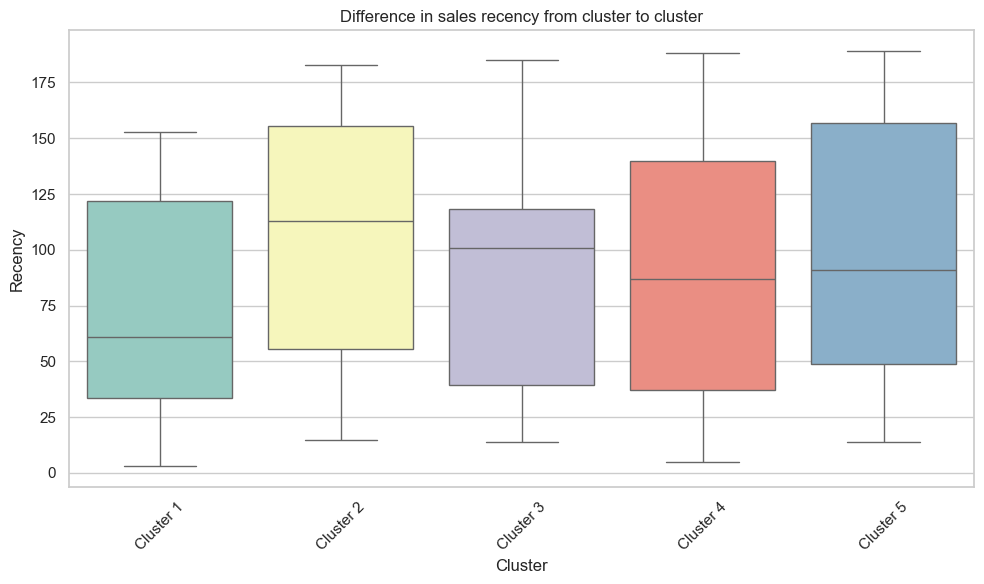

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Datos de ejemplo
x_data = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']
cutoff_quantile = 100
field_to_plot = 'recency'  # Selecciona el campo a visualizar

# Simulación de datos
np.random.seed(0)
customer_history_df = pd.DataFrame({
    'num_cluster5_labels': np.random.randint(0, 5, size=100),
    'recency': np.random.randint(1, 200, size=100)
})

# Preparar datos para cada cluster
y_data = []
for cluster_label in range(5):
    y_cluster = customer_history_df[customer_history_df['num_cluster5_labels'] == cluster_label][field_to_plot].values
    y_cluster = y_cluster[y_cluster < np.percentile(y_cluster, cutoff_quantile)]  # Filtrar valores atípicos
    y_data.append(y_cluster)

# Crear DataFrame con los datos
data = pd.DataFrame({'Cluster': np.repeat(x_data, [len(y) for y in y_data]), 'Recency': np.concatenate(y_data)})

# Configuración de estilo y tamaño de la figura
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Crear el gráfico de caja
sns.boxplot(x='Cluster', y='Recency', data=data, palette="Set3")

# Añadir título y ajustar diseño
plt.title('Difference in sales {} from cluster to cluster'.format(field_to_plot))
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


To describe the different segments of our clusters, we can use boxplots. A boxplot is a graphical representation that provides information about the distribution of a dataset, including the median, quartiles, and outliers.

By representing each cluster as a boxplot, we can visually compare the characteristics of each segment, such as centrality, dispersion, and the presence of outliers. This allows us to identify patterns and differences between the clusters in terms of the variables we are analyzing. For example, if we are using variables like recency, frequency, or monetary value to segment customers, boxplots will help us understand how these variables differ among different groups of customers.
